<a href="https://colab.research.google.com/github/neethu-vm/Deep-learning-neural-networks/blob/main/Food_Recognition_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install dependencies: 
!pip install pyyaml==5.3
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 8.5MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.3-cp37-cp37m-linux_x86_64.whl size=44244 sha256=2446d28fb90ce9457885b7679d19e1888e30ac91c2776c9b28d11ebed5b5db24
  Stored in directory: /root/.cache/pip/wheels/e4/76/4d/a95b8dd7b452b69e8ed4f68b69e1b55e12c9c9624dd962b191
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.9.0+cu102 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# Install torch 1.8.1.
# The Colab's default torch version is 1.9.0+cu102 which is not supported and tested by Detectron2 for now.
!pip install torch==1.8.1+cu102 torchvision==0.9.1+cu102 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 804.1MB 23kB/s 
     |████████████████████████████████| 17.3MB 1.3MB/s 
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.8.1+cu102 which is incompatible.
  Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102


In [1]:
# install detectron2: (Colab has CUDA 10.2 + torch 1.9)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.8/index.html
     |████████████████████████████████| 6.2MB 1.9MB/s 
     |████████████████████████████████| 81kB 5.9MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 112kB 42.6MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=c31ae232409b59df28f3adbb59ddef1d2a1cfce40c6df0a43aa410b7cd025f29
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df777c03d8c67f22c65f97d6f75321087482d05a9b218
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-cp37-none-any.whl size=141231 sha256=0803ccde7b520ea21097a2582f0218a5352eaca4c5dc8631320afac5cd871686
  Stored in directory: /root/.cache/pip/wheels/e3/e2/fa/b78480b448b8579ddf393bebd3f47ee23aa84c89b6a78285c8
Successfully built fvcore antlr4-python3-runtime


In [16]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random, glob

In [2]:
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:

from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

In [4]:

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

#mounting to drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Select food classes

In [6]:
food_classes = ['dosa','egg curry','idiyappam','chai','chicken','cherupayar','curry','puttu']
class_num = len(food_classes)
max_iter = 1000

#Registering the Data set

In [7]:
def get_dataset_dicts(directory):
    classes = food_classes
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = img_anns['imageHeight']
        record["width"] = img_anns['imageWidth']

        print(record["height"], record["width"])
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']]
            py = [a[1] for a in anno['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


In [12]:
for d in ["traindata", "testdata"]:
    DatasetCatalog.register("class0_food_indian_" + d, lambda d=d: get_dataset_dicts('/content/drive/MyDrive/Project1/' + d))
    MetadataCatalog.get("class0_food_indian_" + d).set(thing_classes=food_classes)
#food_metadata = MetadataCatalog.get("class1_food_indian_").set(thing_classes = food_classes)


AssertionError: ignored

In [9]:
food_metadata = MetadataCatalog.get("class0_food_indian_").set(thing_classes = food_classes)

4608 2592
4608 3456
3456 4608
500 500
1080 1080
1080 1080
567 1080
1221 1080
1179 1080
1350 1080
500 500
500 500
500 400
768 768
1080 1080
1350 1080
2583 4056
2592 4608
2592 4608
4608 3456
3456 4608
4608 2592
720 960
1280 720
1280 960
1280 720
1245 1280
1280 958
1024 768
2176 4608
2340 1080
2592 4608
4608 2592
4608 2592
4608 2592
1080 1080
640 640
1600 900
2592 4608
720 960
4608 2592
1920 1080
1280 960
780 1040
1083 1280
1599 1200
1040 780
1040 780
720 1280
1280 720
1156 867
1280 960
1280 590
960 1280
740 888
1156 867
1280 720
1280 720
768 1024
768 1024
1280 720
1024 576
486 807
1030 720
821 720
1599 899
1156 867
1156 867
1280 720
1067 1060
1040 780
1040 780
1280 850
3456 4608
3456 4608
3456 4608
1078 1079


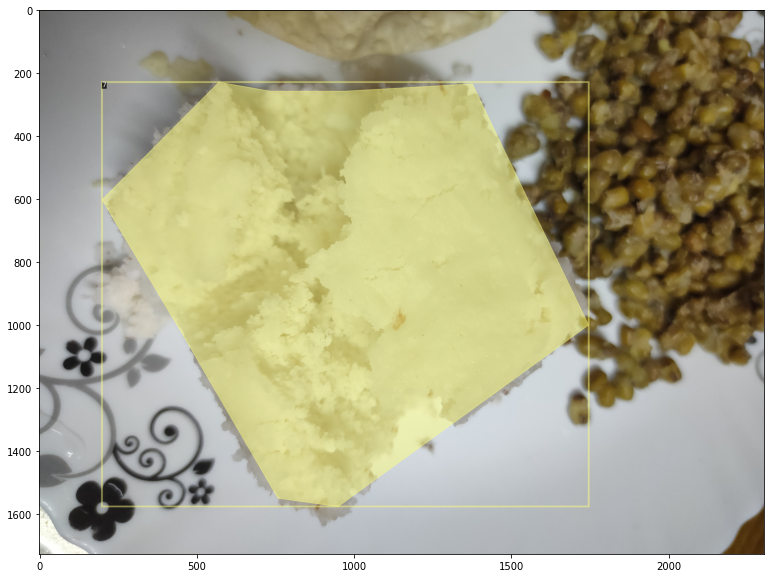

In [17]:
#visualize img annotations randomly
import matplotlib.pyplot as plt
import random

dataset_dicts = get_dataset_dicts("/content/drive/MyDrive/Project1/traindata")
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=food_metadata, scale=0.5)
    v = Visualizer(img[:, :, ::-1], scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

#Training the Model

In [14]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
#from detectron2.modeling import build_model
#model = build_model(cfg)

In [18]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("class0_food_indian_traindata",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.NUM_CLASSES = class_num
cfg.OUTPUT_DIR = '/content/drive/MyDrive/Project1/output/'

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)


[07/17 12:03:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:02, 64.0MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (9, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (9,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (32, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (32,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to

In [19]:
trainer.train()

[07/17 12:03:48 d2.engine.train_loop]: Starting training from iteration 0
[07/17 12:04:02 d2.utils.events]:  eta: 0:08:29  iter: 19  total_loss: 3.011  loss_cls: 2.143  loss_box_reg: 0.1489  loss_mask: 0.6965  loss_rpn_cls: 0.00749  loss_rpn_loc: 0.01078  time: 0.6140  data_time: 0.1924  lr: 4.9953e-06  max_mem: 2844M
[07/17 12:04:17 d2.utils.events]:  eta: 0:09:00  iter: 39  total_loss: 2.849  loss_cls: 1.958  loss_box_reg: 0.1362  loss_mask: 0.6904  loss_rpn_cls: 0.00647  loss_rpn_loc: 0.01096  time: 0.6937  data_time: 0.2748  lr: 9.9902e-06  max_mem: 2930M
[07/17 12:04:30 d2.utils.events]:  eta: 0:08:54  iter: 59  total_loss: 2.453  loss_cls: 1.55  loss_box_reg: 0.1789  loss_mask: 0.6837  loss_rpn_cls: 0.006929  loss_rpn_loc: 0.01246  time: 0.6634  data_time: 0.0974  lr: 1.4985e-05  max_mem: 2930M
[07/17 12:04:41 d2.utils.events]:  eta: 0:08:42  iter: 79  total_loss: 1.894  loss_cls: 1.072  loss_box_reg: 0.1455  loss_mask: 0.6723  loss_rpn_cls: 0.006404  loss_rpn_loc: 0.009094  time

In [18]:
cfg.MODEL.WEIGHTS

'https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl'

In [ ]:
print(cfg.dump())

CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST: []
  TRAIN:
  - class11_food_indian_traindata
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: false
    SIZE:
    - 0.9
    - 0.9
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN:
  - 640
  - 672
  - 704
  - 736
  - 768
  - 800
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES:
    - - -90
      - 0
      - 90
    ASPECT_RATIOS:
    - - 0.5
      - 1.0
      - 2.0
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES:
    - - 32
    - - 64
    - - 128
    - - 256
    - - 512
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resn

In [ ]:
type(cfg)

detectron2.config.config.CfgNode

In [ ]:
#from detectron2.modeling import build_model
#model = build_model(cfg)

In [ ]:
#from detectron2.checkpoint import DetectionCheckpointer
#DetectionCheckpointer(model).load('https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl')


#checkpointer = DetectionCheckpointer(model, save_dir="/content/drive/My Drive/Project/output2/")
#checkpointer.save("model_final.pth")

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

In [ ]:
#model_path = "/content/drive/MyDrive/Project/output1/model_999.pth"

In [ ]:
cfg.MODEL.WEIGHTS

'https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl'

#Use model for Inference

In [20]:
import detectron2
from detectron2.config import get_cfg
import os
from detectron2.engine import DefaultPredictor
import cv2
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt
from detectron2.data.datasets import register_coco_instances

In [ ]:
cfg.MODEL.WEIGHTS

'https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl'

In [ ]:
#cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/Project/output1/model_999.pth'

In [21]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("class0_food_indian_testdata",)
predictor = DefaultPredictor(cfg)

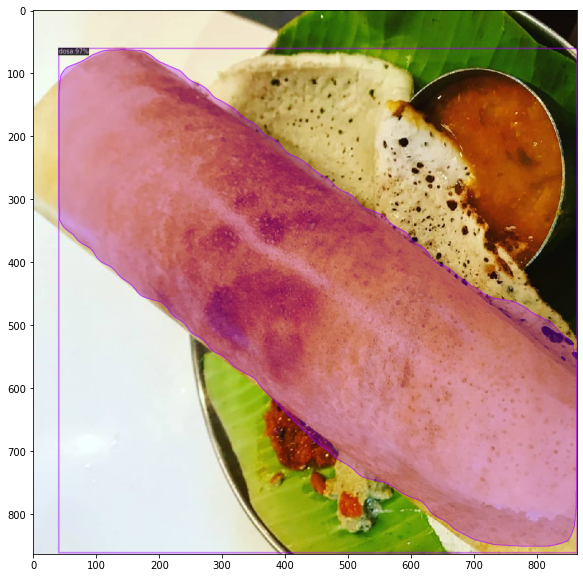

In [33]:
from detectron2.utils.visualizer import ColorMode
filepath = '/content/drive/MyDrive/Project1/testdata/dosatest (6).jpg'
im = cv2.imread(filepath)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
               metadata=food_metadata,
               scale=0.8,
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
               )
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

4608 2592
1080 1080
1080 1080
567 1080
1221 1080
1179 1080
1350 1080
1080 1080
1350 1080
2583 4056
2592 4608
720 960
1280 720
1280 960
1280 720
1245 1280
1280 958
2176 4608
2340 1080
2592 4608
1080 1080
640 640
1600 900
2592 4608
720 960
4608 2592
1920 1080
1280 960
780 1040
1599 1200
1040 780
1040 780
720 1280
1280 720
1156 867
1280 960
740 888
1156 867
1280 720
768 1024
768 1024
1280 720
1024 576
486 807
1030 720
821 720
1599 899
1040 780
1040 780
1280 850
3456 4608
3456 4608
1078 1079


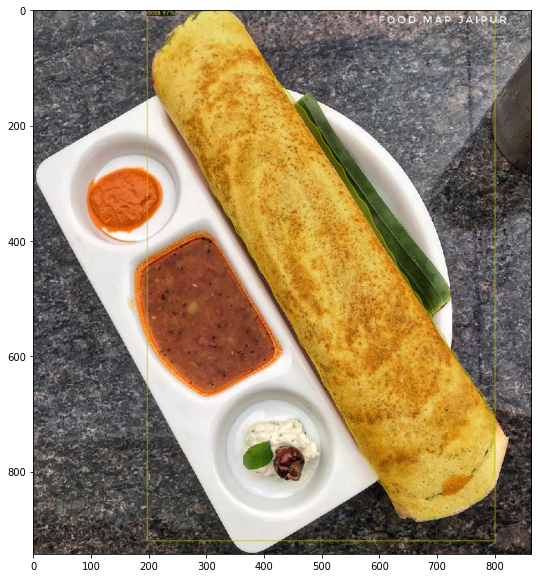

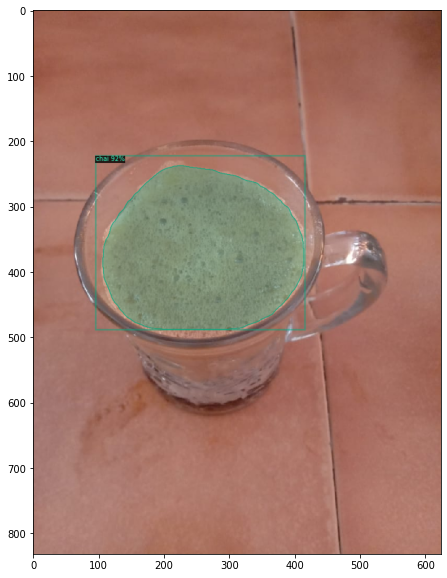

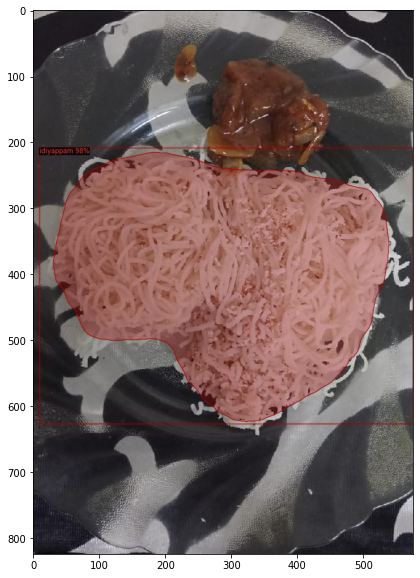

In [35]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_dataset_dicts('/content/drive/MyDrive/Project1/testdata')
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=food_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()